In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
import lmfit
from lmfit.models import LorentzianModel

In [2]:
# bokeh packages
from bokeh.io import output_file,show,output_notebook,push_notebook, curdoc
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper, Select, Slider
from bokeh.palettes import Category10
from bokeh.layouts import row,column,gridplot,widgetbox
from bokeh.models.widgets import Tabs,Panel
output_notebook()

Loading BokehJS ...

In [3]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams.update({'font.size': 18})
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'
rcParams['xtick.top'] = False
rcParams['ytick.right'] = False
rcParams['xtick.major.size'] = 10
rcParams['ytick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['xtick.minor.visible'] = False
rcParams['ytick.minor.visible'] = False

In [4]:
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

# Function to calculate the Gaussian with constants a, b, and c
def gaussian1(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

#Function to calculate the lorenzian
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2) #   lo = amp2 / (1 + ((x-cen)/(gamma/2))**2)


In [5]:
#loading data using numpy
def load_data(filename):
    return np.genfromtxt(filename, delimiter='\t')

In [6]:
#creating a dictionary for all samples A1-A8
def load_alldata(data):
    samples = {}
    for sample in data:
        d = load_data(sample)
        name = sample[1:4] 
        samples[name] = d
    return samples

In [7]:
#selecting range 
def extract_peak(sample, xrange):
    idx = np.logical_and(xrange[0] < sample[:,0], sample[:,0] < xrange[1])
    return sample[idx,:]

In [8]:
#plotting using Bokeh
def mp(data,xrange=[0.03,0.5]):
    f = figure(y_axis_type="log") #x_axis_type='log')
    for k,color in zip(data,Category10[10]):
        d = extract_peak(data[k],xrange)
        f.line(d[:,0],d[:,1],color=color,line_width=3, legend_label=k)
    #f.legend.click_policy = 'hide'
    show(f)

In [9]:
def tabs_plot(data, xrange=[0.03,0.5]):
    tabs=[]
    for k in data:
        d = extract_peak(data[k],xrange)
        f=figure(x_axis_label='Q', y_axis_label="Intensity", y_axis_type='log')
        x=d[:,0]
        y=d[:,1]
        f.circle(x, y, size=10,fill_color='red', alpha=0.6, line_color=None,
         hover_fill_color='black', hover_alpha=0.6,hover_line_color='white')
        
        hover = HoverTool(tooltips=[ ('Q', '@x'), ('I', '@y')], mode='mouse')
        f.add_tools(hover)
        tab = Panel(child=f, title=k)
        tabs.append(tab)
    layout = Tabs(tabs=tabs)
    show(layout)

In [10]:
data_10k=['SAF1_00066.dat', 'SAF2_00067.dat',
        'SAF3_00068.dat','SAF4_00069.dat',
        'SAF5_00070.dat', 'SAF6_00071.dat',
        'SAF7_00072.dat','SAF8_00073.dat','Swater_00075.dat']
A_10k=load_alldata(data_10k)
tabs_plot(A_10k)

In [11]:
#creating gaussian  #gaussian(x, center, width, height, background=0)
def gaussian(x, center, width, height, background=0):   
    return height * np.exp(-(x - center)**2/(2*width**2)) +background

In [12]:
#creating two gaussian
def two_gaussians(x, h1, c1, w1, h2, c2, w2, background=0):
    return (gaussian(x, h1, c1, w1, background=0) +
        gaussian(x, h2, c2, w2, background=0)  + background)


In [13]:
#creating three gaussian
def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, background=0):
    return (gaussian(x, h1, c1, w1, background=0) +
        gaussian(x, h2, c2, w2, background=0) +
        gaussian(x, h3, c3, w3, background=0) + background)


In [14]:
#using lmfit defining model for gaussian and for fitting 
gmodel1 = lmfit.Model(gaussian,independent_vars='x',nan_policy='omit')
gmodel2 = lmfit.Model(two_gaussians,independent_vars='x',nan_policy='omit')
gmodel3 = lmfit.Model(three_gaussians,independent_vars='x',nan_policy='omit')

gmodel=[gmodel1,gmodel2,gmodel3]

In [15]:
#changing parameters initial, max, and min value
#changing parameters initial, max, and min value
gpars1 = gmodel1.make_params(width=0.0001, center=0, height=0,background=0)
gpars1['width'].set(vary=True, min=0.001)
gpars1['center'].set(min=0, max=0.4)
gpars1['background'].set(min=0)
gpars1['height'].set(min=0)



In [16]:
#changing parameters initial, max, and min value
gpars2 = gmodel2.make_params(background=0, c1=0, c2=0, w1=0.001, w2=0.001, h1=0, h2=0)
gpars2['w1'].set(min=0.001)
gpars2['w2'].set(min=0.001)
gpars2['c1'].set(min=0, max=0.4)
gpars2['c2'].set(min=0, max=0.4)
gpars2['background'].set(min=0)
gpars2['h1'].set(min=0)
gpars2['h2'].set(min=0)
gpars2

Parameters([('h1', <Parameter 'h1', value=0, bounds=[0:inf]>),
            ('c1', <Parameter 'c1', value=0, bounds=[0:0.4]>),
            ('w1', <Parameter 'w1', value=0.001, bounds=[0.001:inf]>),
            ('h2', <Parameter 'h2', value=0, bounds=[0:inf]>),
            ('c2', <Parameter 'c2', value=0, bounds=[0:0.4]>),
            ('w2', <Parameter 'w2', value=0.001, bounds=[0.001:inf]>),
            ('background', <Parameter 'background', value=0, bounds=[0:inf]>)])

In [17]:
#changing parameters initial, max, and min value
gpars3 = gmodel3.make_params(background=0, c1=0, c2=0, c3=0,
                             w1=0.001, w2=0.001, w3=0.001,h1=0, h2=0, h3=0)
gpars3['w1'].set(min=0.001)
gpars3['w2'].set(min=0.001)
gpars3['w3'].set(min=0.001)
gpars3['c1'].set(min=0, max=0.4)
gpars3['c2'].set(min=0, max=0.4)
gpars3['c3'].set(min=0, max=0.4)
gpars3['background'].set(min=0)
gpars3['h1'].set(min=0)
gpars3['h2'].set(min=0)
gpars3['h3'].set(min=0)
gpars3

Parameters([('h1', <Parameter 'h1', value=0, bounds=[0:inf]>),
            ('c1', <Parameter 'c1', value=0, bounds=[0:0.4]>),
            ('w1', <Parameter 'w1', value=0.001, bounds=[0.001:inf]>),
            ('h2', <Parameter 'h2', value=0, bounds=[0:inf]>),
            ('c2', <Parameter 'c2', value=0, bounds=[0:0.4]>),
            ('w2', <Parameter 'w2', value=0.001, bounds=[0.001:inf]>),
            ('h3', <Parameter 'h3', value=0, bounds=[0:inf]>),
            ('c3', <Parameter 'c3', value=0, bounds=[0:0.4]>),
            ('w3', <Parameter 'w3', value=0.001, bounds=[0.001:inf]>),
            ('background', <Parameter 'background', value=0, bounds=[0:inf]>)])

In [18]:
gpars=[gpars1, gpars2, gpars3]

In [19]:
#function for fitting
gpars=[gpars1, gpars2, gpars3]

def fit_set(data,position,gauss_two=True, gauss_three=True, plot=True):
    r = []; ks = []
    for k in data:
        #print(k)
        sample = data[k]
        d = extract_peak(sample,position)
        center = (position[0]+position[1])/2
        c2=center*2
        c3=center*3
        height = (d[:,1].max())/6
        h2=height/10
        h3=h2/2
        
        if gauss_two:
            fit = gmodel[1].fit(d[:,1],gpars[1],x=d[:,0],h1=height,h2=h2,c1=center,c2=c2,
                       method='least_squares')
        elif gauss_three:
            fit = gmodel[2].fit(d[:,1],gpars[2],x=d[:,0],h1=height,h2=h2,h3=h3,c1=center,
                       c2=c2, c3=c3, method='least_squares')
        else:
            fit = gmodel[0].fit(d[:,1],gpars[0],x=d[:,0],height=height,center=center,
                       method='least_squares')
        if plot:
            fit.plot()
            plt.title(f'{k}')
            plt.xlabel('q')
            plt.ylabel('I')
        ks.append(k)
        r.append(fit.best_values)
    return pd.DataFrame(r,index=ks)


In [ ]:
#data after averiging- A1-A8 and water
data_10k=['SAF1_00066.dat', 'SAF2_00067.dat',
        'SAF3_00068.dat','SAF4_00069.dat',
        'SAF5_00070.dat', 'SAF6_00071.dat',
        'SAF7_00072.dat','SAF8_00073.dat','Swater_00075.dat']

#Loading all data in dictionary
A_10k=load_alldata(data_10k)

#plotting using Bokeh
mp(A_10k)
tabs_plot(A_10k)
#10 K   just after vortex-range
#fitting using fit_set function. For two gaussian make gauss_two true and for three gausian make gauss_three True.
fit_set(A_10k,[0.0075,0.45], gauss_two=True, gauss_three=False, plot=True)

In [ ]:
#10 K   just after vortex-range(0.03-0.07)
#fitting using fit_set function. For two gaussian make gauss_two true and for three gausian make gauss_three True.
mp(A_10k)
fit_set(A_10k,[0.1,0.45], gauss_two=True, gauss_three=False, plot=True)

In [ ]:
#10 K   just after vortex-range(0.1-0.12)
#fitting using fit_set function. For two gaussian make gauss_two true and for three gausian make gauss_three True.
mp(A_10k)
fit_set(A_10k,[0.075,0.12], gauss_two=True, gauss_three=False, plot=True)

In [ ]:
#10 K   just after vortex-range(0.1-0.4)
#fitting using fit_set function. For two gaussian make gauss_two true and for three gausian make gauss_three True.
fit_set(A_10k,[0.03,0.06], gauss_two=False, gauss_three=False, plot=True)

In [ ]:
#10 K   just after vortex-range(0.1-0.4)
#fitting using fit_set function. For two gaussian make gauss_two true and for three gausian make gauss_three True.
mp(A_10k)
fit_set(A_10k,[0.1,0.12], gauss_two=False, gauss_three=False, plot=True)

In [ ]:
#25 K   just after vortex
data_25k=['SAF1_00079.dat', 'SAF2_00080.dat',
        'SAF3_00081.dat','SAF4_00082.dat',
        'SAF5_00083.dat', 'SAF6_00084.dat',
        'SAF7_00085.dat','SAF8_00086.dat','Swater_00088.dat']

A_25k=load_alldata(data_25k)

mp(A_25k)

fit_set(A_25k,[0.1,0.4],gauss_two=True, gauss_three=True,plot=True)

In [ ]:
#50 K   just after vortex
data_50k=['SAF1_00092.dat', 'SAF2_00093.dat',
        'SAF3_00094.dat','SAF4_00095.dat',
        'SAF5_00096.dat', 'SAF6_00097.dat',
        'SAF7_00098.dat','SAF8_00099.dat','Swater_00101.dat']

A_50k=load_alldata(data_50k)

mp(A_50k)

fit_set(A_50k,[0.1,0.4],gauss_two=True, gauss_three=False,plot=True)

h1        c1        w1            h2        c2        w2  \
AF1  2.875960e-02  0.004396  0.021640  4.153193e-17  0.023530  0.101997   
AF2  2.713611e-02  0.005137  0.024639  1.956722e-16  0.023317  0.080232   
AF3  2.653948e-02  0.005454  0.029282  8.288401e-18  0.024029  0.089660   
AF4  2.831863e-02  0.004358  0.019307  2.476295e-16  0.022214  0.097034   
AF5  2.145124e-02  0.007241  0.063239  6.855921e-14  0.024259  0.080745   
AF6  2.827707e-02  0.004450  0.020585  7.942407e-07  0.023186  0.088313   
AF7  2.335923e-02  0.006423  0.034718  2.651264e-17  0.022129  0.090711   
AF8  2.272441e-02  0.006953  0.040798  3.468826e-03  0.023276  0.069022   
wat  6.808603e-10  0.012089  0.671859  2.542417e-15  0.023727  0.075742   

     background  
AF1    0.086301  
AF2    0.090862  
AF3    0.091042  
AF4    0.087175  
AF5    0.092959  
AF6    0.087986  
AF7    0.090454  
AF8    0.089330  
wat    0.080110

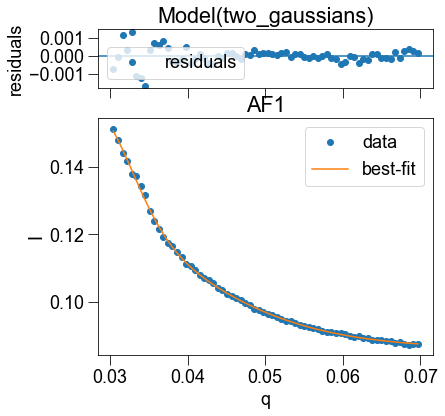

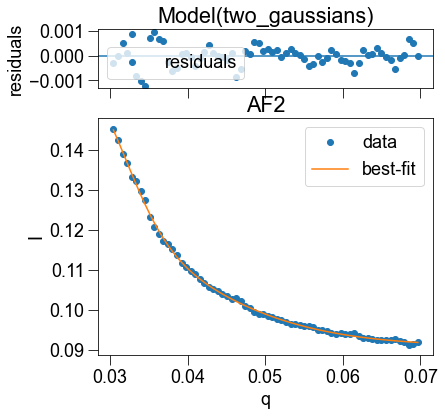

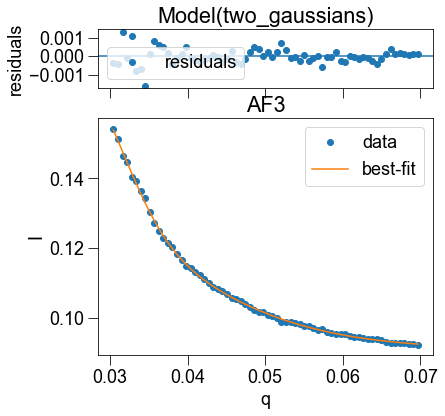

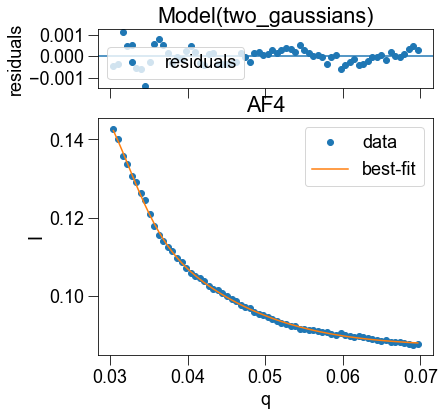

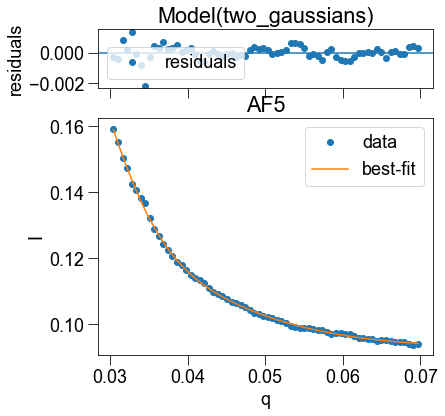

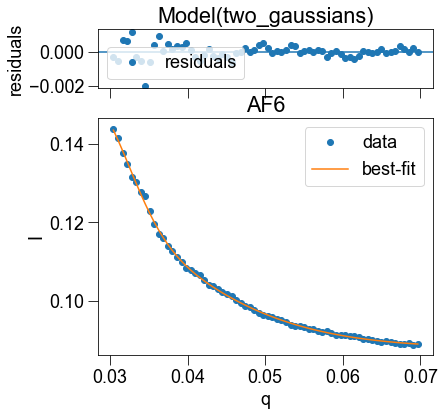

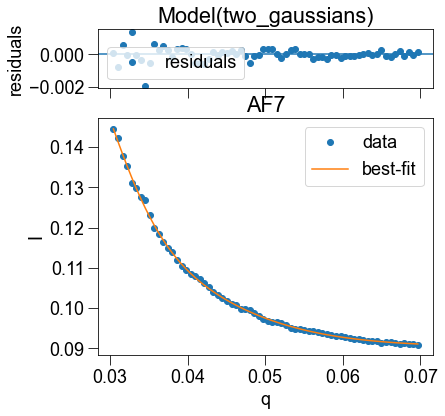

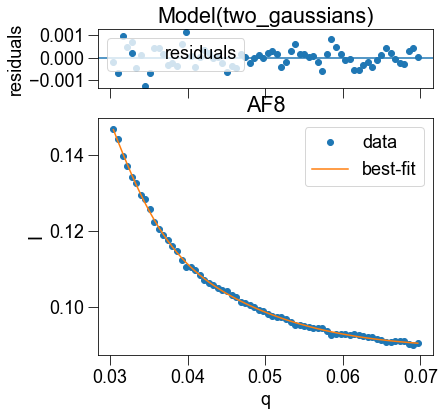

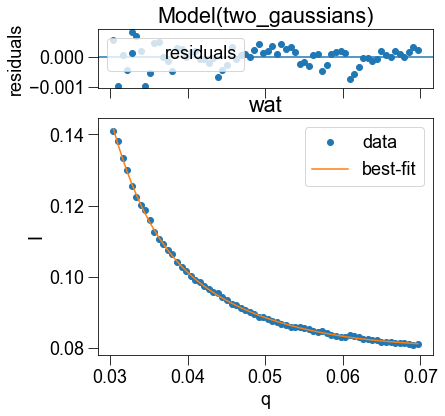

In [20]:
#37 K   just after vortex
data_37k=['SAF1_00105.dat', 'SAF2_00106.dat',
        'SAF3_00107.dat','SAF4_00108.dat',
        'SAF5_00109.dat', 'SAF6_00110.dat',
        'SAF7_00111.dat','SAF8_00112.dat','Swater_00114.dat']

A_37k=load_alldata(data_37k)

mp(A_37k)

fit_set(A_37k,[0.03,0.07],gauss_two=True, gauss_three=False,plot=True)

h1        c1        w1            h2        c2         w2  \
AF1   321.351583  0.000184  0.113105  6.666000e-10  0.005829  13.889834   
AF2   303.222113  0.000187  0.514431  5.727266e-10  0.005794  14.071149   
AF3   368.529391  0.000612  0.823551  4.513963e-10  0.005850  13.999201   
AF4   374.332735  0.000406  0.162894  1.906233e-10  0.005780  14.311322   
AF5   581.654026  0.000287  1.720543  4.985247e-10  0.005888  14.268601   
AF6   356.953359  0.000083  0.194307  5.905430e-10  0.005801  14.269040   
AF7   491.411478  0.399404  0.883802  3.178674e-10  0.005718  14.926694   
AF8   524.646945  0.399934  0.463756  8.719470e-10  0.005743  14.856334   
wat  1146.374574  0.399716  0.198904  3.685472e-10  0.005763  15.627857   

     background  
AF1    0.088096  
AF2    0.093666  
AF3    0.092898  
AF4    0.088730  
AF5    0.096313  
AF6    0.089996  
AF7    0.089603  
AF8    0.089862  
wat    0.082999

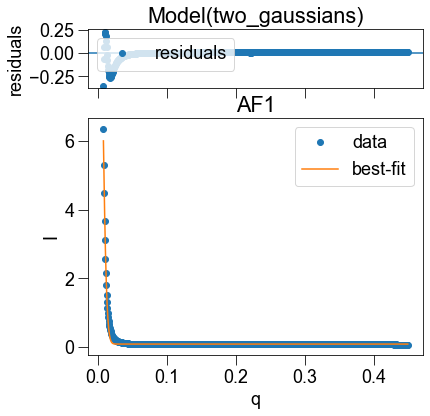

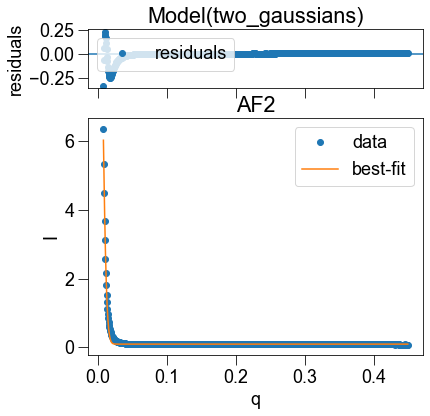

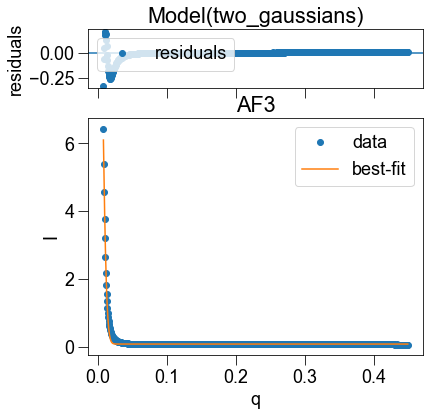

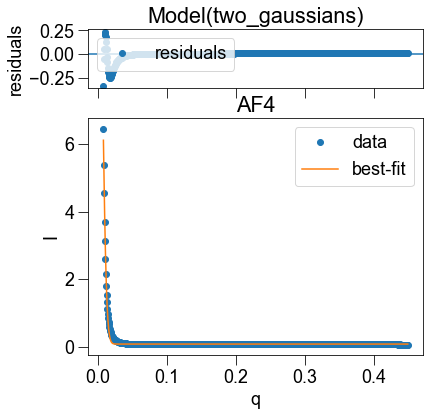

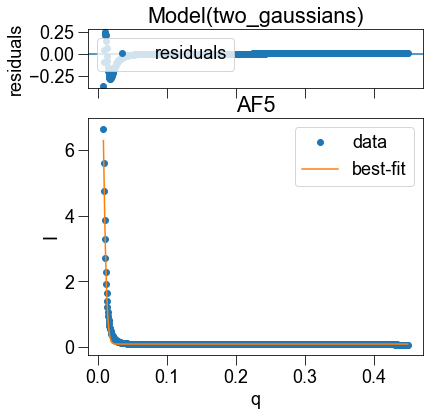

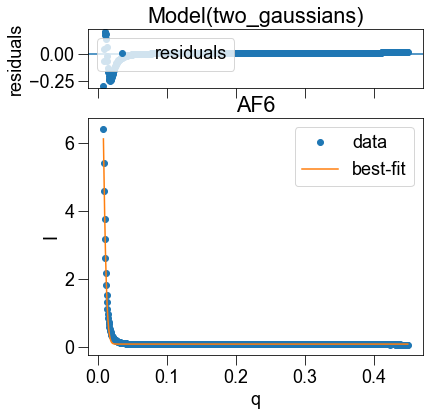

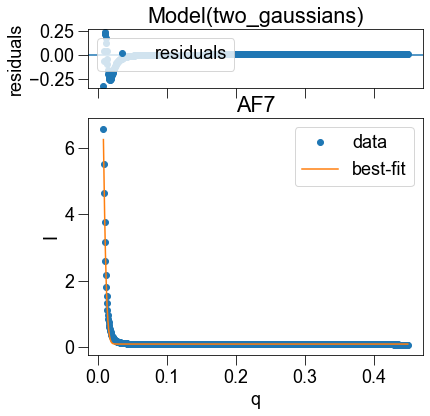

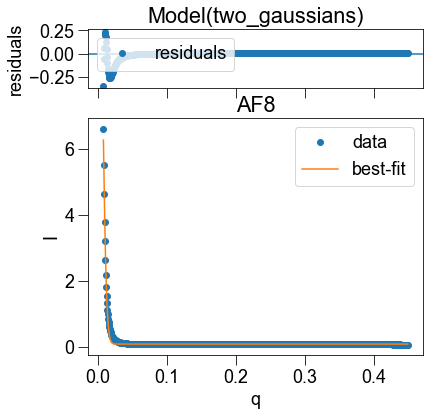

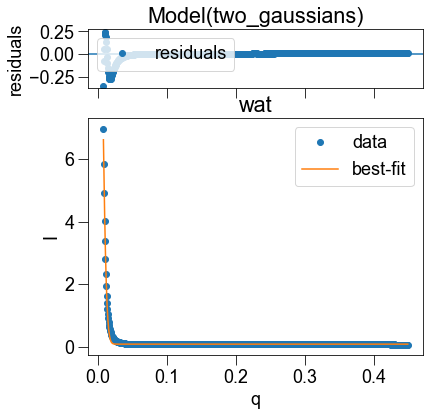

In [31]:
#37 K   just after vortex
data_37k=['SAF1_00105.dat', 'SAF2_00106.dat',
        'SAF3_00107.dat','SAF4_00108.dat',
        'SAF5_00109.dat', 'SAF6_00110.dat',
        'SAF7_00111.dat','SAF8_00112.dat','Swater_00114.dat']

A_37k=load_alldata(data_37k)

mp(A_37k)
tabs_plot(A_37k)
fit_set(A_37k,[0.0075,0.45],gauss_two=True, gauss_three=False,plot=True)

In [ ]:
#Phase seprated sample

In [ ]:
#10 K phase seprated
data_ps_10k=['SAF1_00354.dat', 'SAF2_00355.dat',
        'SAF3_00356.dat','SAF4_00357.dat',
        'SAF5_00358.dat', 'SAF6_00359.dat',
        'SAF7_00360.dat','SAF8_00361.dat','Swater_00363.dat']

Ap_10k=load_alldata(data_ps_10k)

mp(Ap_10k)

fit_set(Ap_10k,[0.03,0.07],gauss_two=False, gauss_three=True,plot=True)

In [ ]:
#25 K phase seprated
data_ps_25k=['SAF1_00367.dat', 'SAF2_00368.dat',
        'SAF3_00369.dat','SAF4_00370.dat',
        'SAF5_00371.dat', 'SAF6_00372.dat',
        'SAF7_00373.dat','SAF8_00374.dat','Swater_00376.dat']

Ap_25k=load_alldata(data_ps_25k)

mp(Ap_25k)

fit_set(Ap_25k,[0.03,0.07],gpars,gauss_two=False, gauss_three=True,plot=True)

In [ ]:
#50 K phase seprated
data_ps_50k=['SAF1_00380.dat', 'SAF2_00381.dat',
        'SAF3_00382.dat','SAF4_00383.dat',
        'SAF5_00384.dat', 'SAF6_00385.dat',
        'SAF7_00386.dat','SAF8_00387.dat','Swater_00389.dat']

Ap_50k=load_alldata(data_ps_50k)

mp(Ap_50k)

fit_set(Ap_50k,[0.1,0.4],gauss_two=False, gauss_three=True,plot=True)

h1        c1        w1            h2        c2        w2  \
AF1  1.035580e-22  0.024963  0.306789  2.785304e-25  0.010248  5.310189   
AF2  6.152006e-23  0.023664  0.328706  6.379739e-26  0.010169  5.135187   
AF3  2.013574e-21  0.025052  0.304603  4.853155e-20  0.010367  4.898365   
AF4  1.483259e-21  0.024191  0.307190  1.703950e-24  0.010274  4.985664   
AF5  1.602615e-20  0.010243  5.206051  1.972687e-22  0.024096  0.319882   
AF6  8.101189e-19  0.024071  0.320449  1.862060e-22  0.010318  5.107885   
AF7  8.918323e-33  0.026405  0.281321  1.379341e-30  0.010601  4.834204   
AF8  5.368072e-26  0.024994  0.298892  3.187024e-25  0.010348  5.035411   
wat  2.634252e-22  0.024032  0.324892  6.039937e-21  0.010238  5.462192   

     background  
AF1    0.081312  
AF2    0.088836  
AF3    0.087193  
AF4    0.082820  
AF5    0.090030  
AF6    0.083676  
AF7    0.081481  
AF8    0.083460  
wat    0.076526

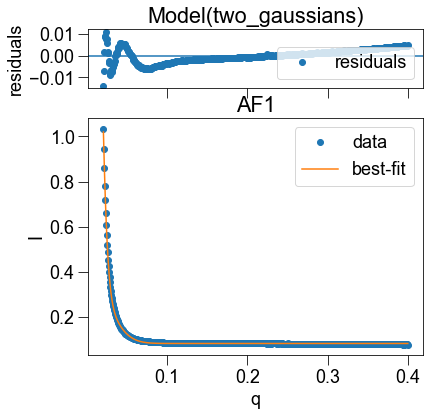

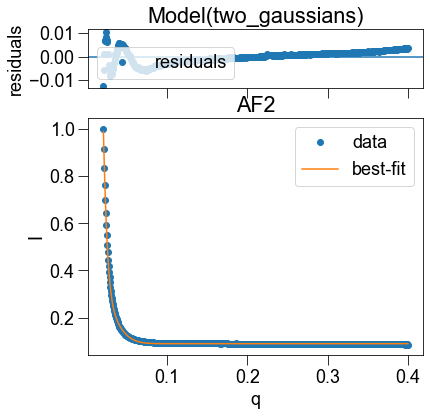

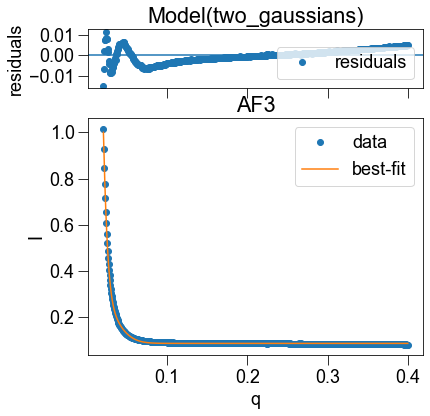

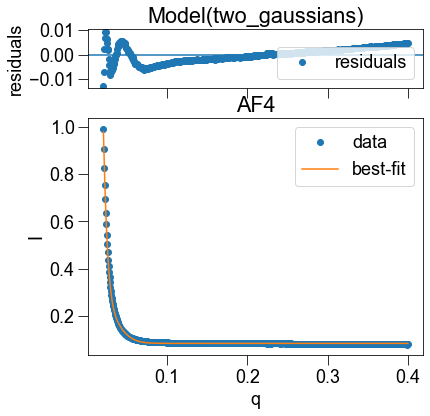

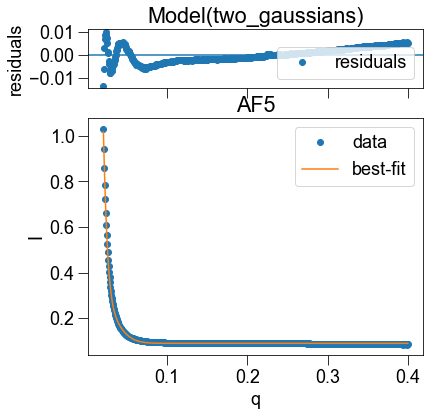

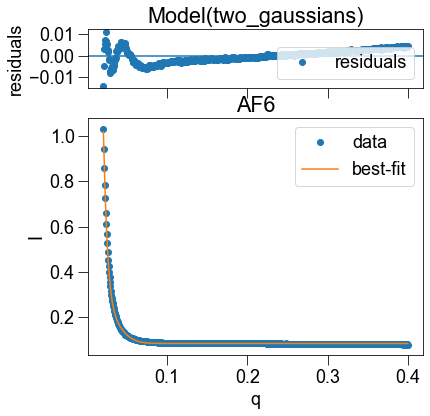

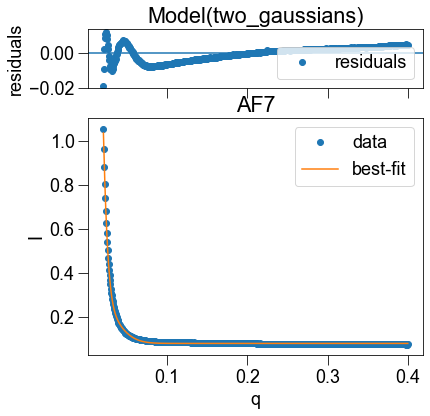

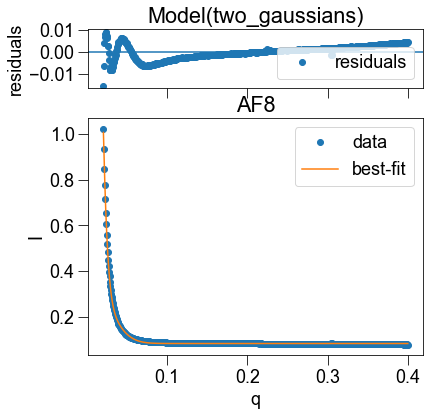

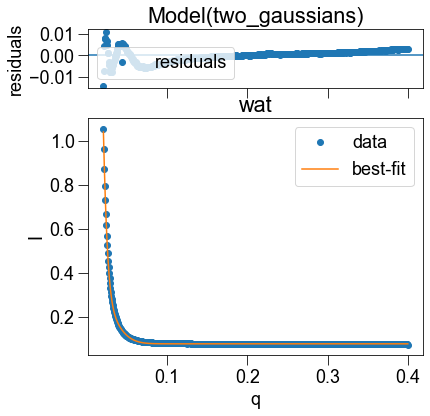

In [30]:
#37 K phase seprated
data_ps_37k=['SAF1_00393.dat', 'SAF2_00394.dat',
        'SAF3_00395.dat','SAF4_00396.dat',
        'SAF5_00397.dat', 'SAF6_00398.dat',
        'SAF7_00399.dat','SAF8_00400.dat','Swater_00402.dat']

Ap_37k=load_alldata(data_ps_37k)

mp(Ap_37k)
tabs_plot(Ap_37k)
fit_set(Ap_37k,[0.02,0.4],gauss_two=True, gauss_three=False,plot=True)

In [32]:
#Guinier Approximation
#ln(q)=lnI0-Rg**2/3*q**2
def guinier(x, slope, intensity, background=0):   
    return (np.log(intensity) - slope*x) +background

guimodel = lmfit.Model(guinier,independent_vars='x',nan_policy='omit')

guipars=guimodel.make_params(intensity=0.003,background=0)

In [33]:
#changing parameters initial, max, and min value
guipars=guimodel.make_params(intensity=0.003,background=0)
guipars['slope'].value = 0.003
guipars['intensity'].set(min=0.01)
guipars['background'].set(min=0,max=100)


In [34]:
def gui_fit(data,position, plot=True):
    r = []; ks = []
    for k in data:
        #print(k)
        sample = data[k]
        d = extract_peak(sample,position)
        x=d[:,0]*d[:,0]  #q2
        y=np.log(d[:,1])
        fit = guimodel.fit(y,guipars,x=x,
                       method='powell')
        if plot:
            fit.plot()
            plt.title(f'{k}')
            plt.xlabel('q2')
            plt.ylabel('ln(I)')
        ks.append(k)
        r.append(fit.best_values)
        df=pd.DataFrame(r,index=ks)
    df['size_nm']=(np.sqrt(3*df['slope']))/10
    return df

In [35]:
#data after averiging- A1-A8 and water
data_10k=['SAF1_00066.dat', 'SAF2_00067.dat',
        'SAF3_00068.dat','SAF4_00069.dat',
        'SAF5_00070.dat', 'SAF6_00071.dat',
        'SAF7_00072.dat','SAF8_00073.dat','Swater_00075.dat']

#Loading all data in dictionary
A_10k=load_alldata(data_10k)

#plotting using Bokeh
mp(A_10k)

slope  intensity  background    size_nm
AF1  13577.529899   0.477060    3.204611  20.182316
AF2  13720.829852   0.476925    3.190491  20.288541
AF3  13465.749911   0.477074    3.205802  20.099067
AF4  13754.630445   0.476943    3.220707  20.313516
AF5  13719.462341   0.476881    3.216097  20.287530
AF6  13629.475592   0.476954    3.222467  20.220887
AF7  13845.408200   0.477027    3.201338  20.380438
AF8  13769.785650   0.476882    3.216159  20.324703
wat  13950.767028   0.482072    3.244629  20.457835

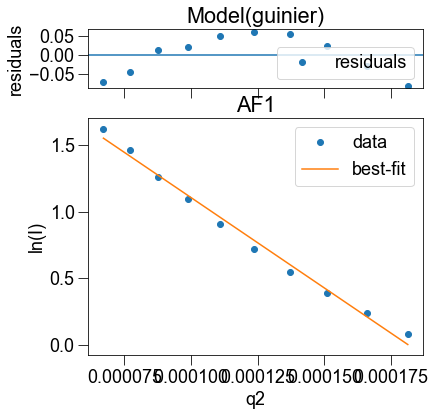

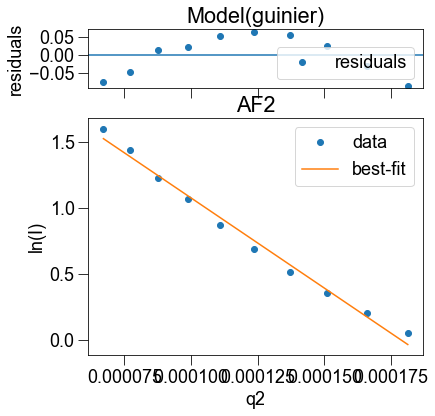

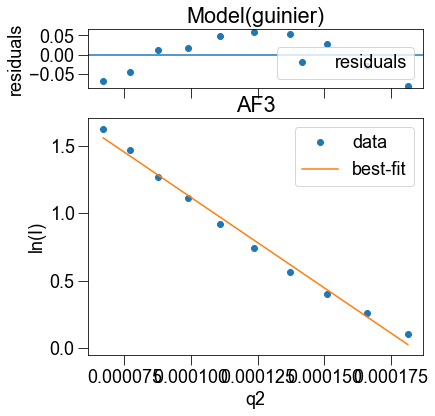

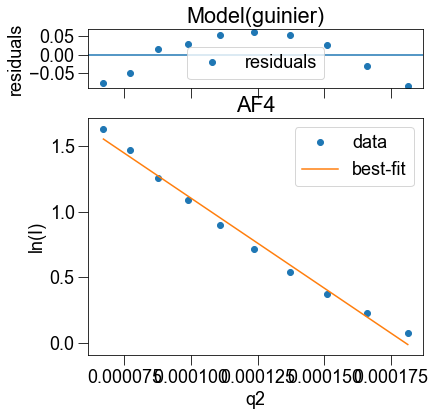

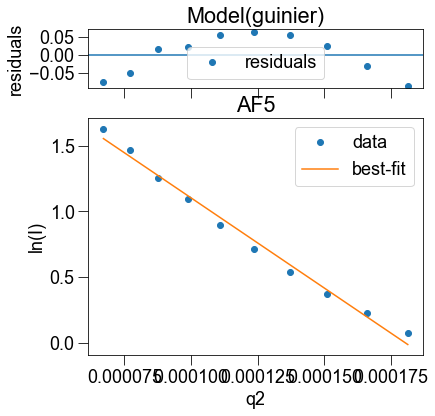

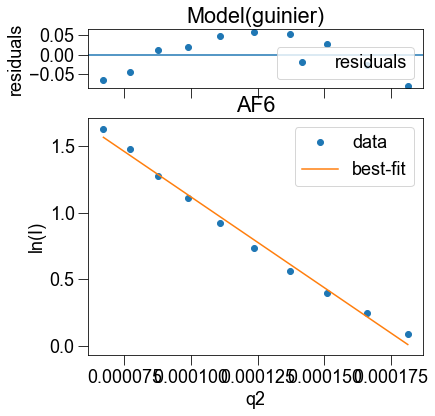

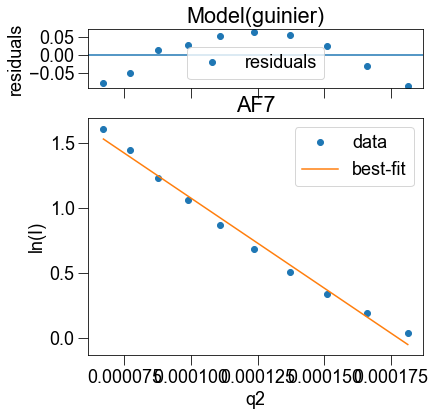

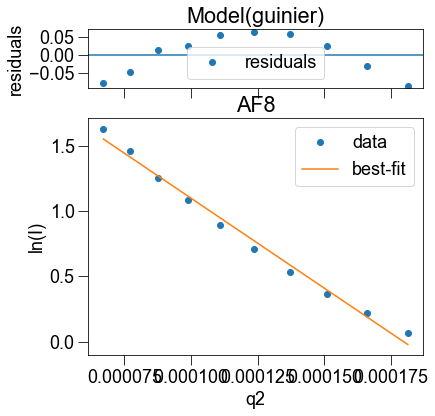

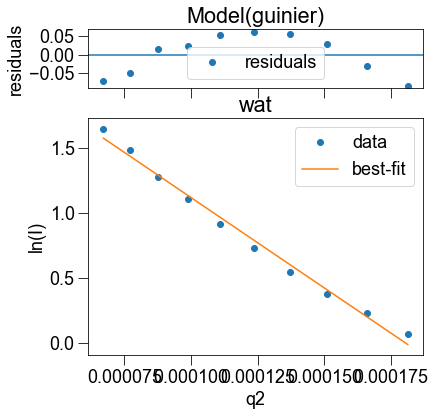

In [36]:
gui_fit(A_10k,[0.008,0.014], plot=True)

slope  intensity  background    size_nm
AF1  8316.246345   2.332810    1.001031  15.795170
AF2  8417.550784   2.310461    0.991736  15.891083
AF3  8270.752485   2.335709    1.009159  15.751907
AF4  8422.063271   2.335270    1.008034  15.895342
AF5  8389.054795   2.333938    1.004236  15.864162
AF6  8371.236917   2.338183    1.015504  15.847306
AF7  8450.078093   2.314557    0.991148  15.921757
AF8  8401.340733   2.332812    1.001037  15.875775
wat  8611.600199   2.356851    1.032028  16.073208

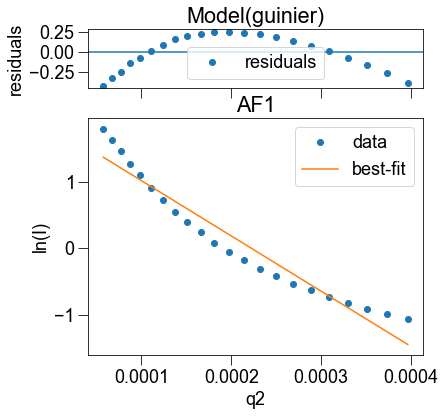

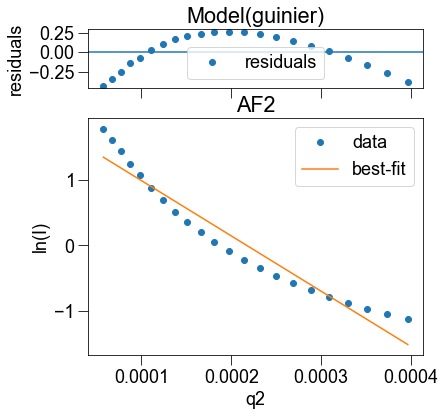

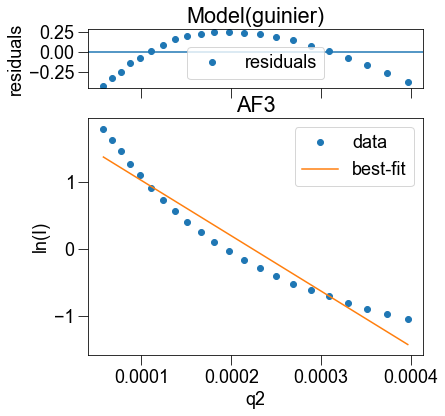

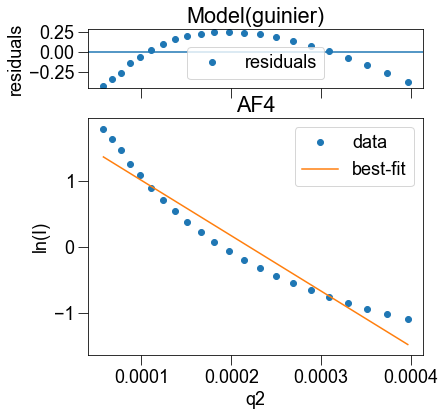

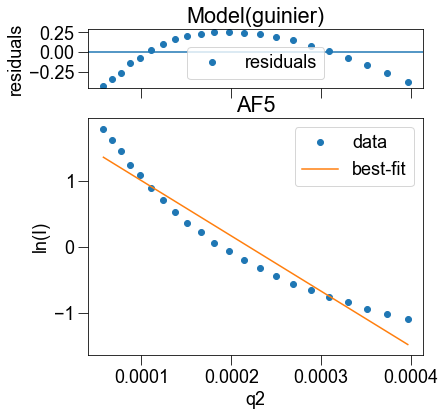

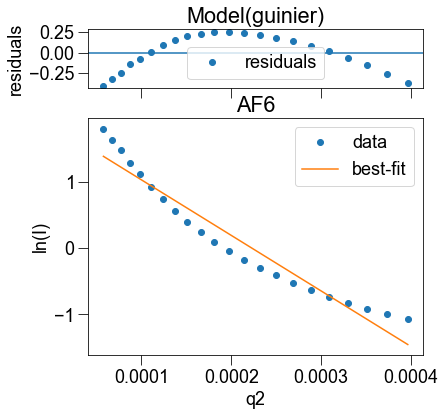

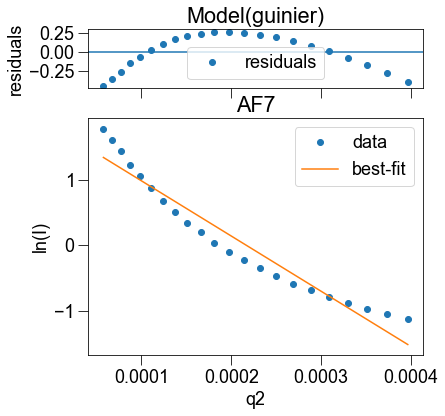

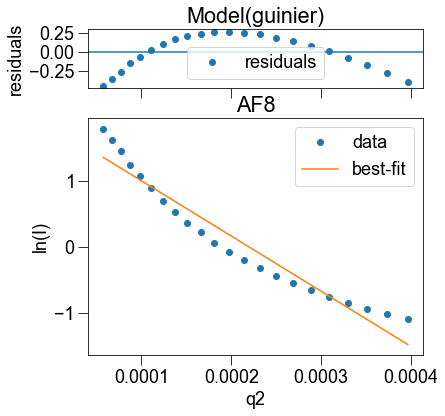

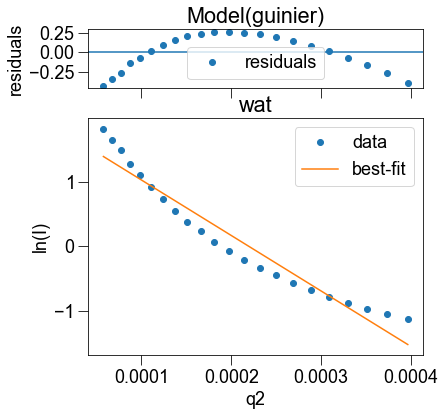

In [37]:
gui_fit(A_10k,[0.0075,0.02], plot=True)


In [53]:
#Porod law
def porod(data,xrange=[0.02,1.1]):
    f = figure(title='Porod Analysis', y_axis_type="log",  y_axis_label='q^4 * Intensity', x_axis_label='q') #x_axis_type='log')
    for k,color in zip(data,Category10[10]):
        d = extract_peak(data[k],xrange)
        y=(np.power(d[:,0], 4))*d[:,1]
        f.line(d[:,0],y,line_width=2,color=color,legend_label=k)
    #f.legend.click_policy = 'hide'
    show(f)

In [54]:
#kratky law
def kratky(data,xrange=[0.02,1.1]):
    f = figure(title='Kratky Analysis', y_axis_type="log",  y_axis_label='q^2 * Intensity', x_axis_label='q') #x_axis_type='log')
    for k,color in zip(data,Category10[10]):
        d = extract_peak(data[k],xrange)
        y=(np.power(d[:,0], 2))*d[:,1]
        f.line(d[:,0],y,line_width=2,color=color,legend_label=k)
    #f.legend.click_policy = 'hide'
    show(f)

In [55]:
#data after averiging- A1-A8 and water
data_10k=['SAF1_00066.dat', 'SAF2_00067.dat',
        'SAF3_00068.dat','SAF4_00069.dat',
        'SAF5_00070.dat', 'SAF6_00071.dat',
        'SAF7_00072.dat','SAF8_00073.dat','Swater_00075.dat']

#Loading all data in dictionary
A_10k=load_alldata(data_10k)

#plotting using Bokeh
porod(A_10k)
kratky(A_10k)

In [ ]:
#50 K   just after vortex
data_50k=['SAF1_00092.dat', 'SAF2_00093.dat',
        'SAF3_00094.dat','SAF4_00095.dat',
        'SAF5_00096.dat', 'SAF6_00097.dat',
        'SAF7_00098.dat','SAF8_00099.dat','Swater_00101.dat']

A_50k=load_alldata(data_50k)

porod(A_50k)
kratky(A_50k)

In [56]:
#37 K   just after vortex
data_37k=['SAF1_00105.dat', 'SAF2_00106.dat',
        'SAF3_00107.dat','SAF4_00108.dat',
        'SAF5_00109.dat', 'SAF6_00110.dat',
        'SAF7_00111.dat','SAF8_00112.dat','Swater_00114.dat']

A_37k=load_alldata(data_37k)

porod(A_37k)
kratky(A_37k)